In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.units as u
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits

import scipy.stats

In [2]:
plt.style.use('notebook')

In [3]:
t = Table.read('../data/rcat.fits')
ind = np.isfinite(t['GAIADR2_PMRA']) & (t['FLAG']==0) & (t['SNR']>10) & (t['E_tot_pot1']<0)
t = t[ind]
print(len(t))

age = 10**t['logAge']*1e-9
age_lerr = age - 10**(t['logAge']-t['logAge_lerr'])*1e-9
age_uerr = 10**(t['logAge']+t['logAge_uerr'])*1e-9 - age
age_err = 0.5 * (age_lerr + age_uerr)
age_err_cons = np.maximum(age_lerr, age_uerr)
age_err_min = 1
age_err_cons[age_err_cons<age_err_min] = age_err_min
age_invar = (age_err_cons)**-2

/usr/lib64/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
/usr/lib64/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


27962


In [4]:
blue = '#0039d3'
purple = '#4700d3'
orange = '#ff6200'
pink = '#ee0449'

In [5]:
ind_all = np.ones(len(t), dtype='bool')
ind_z = (np.abs(t['Z_gal'])<1)
loggmin, loggmax = 3.8, 4.3
ind_safeage = (t['logg']>loggmin) & (t['logg']<loggmax) #& (t['logg_err']<0.1)
# ind_safeage = (t['logg']>3.8) & (t['logg']<4.3) & (age_err/age<0.15)
print(np.sum(ind_safeage))

11034


In [6]:
ind_highe = (t['eccen_pot1']>0.75)
ind_lowe = (t['eccen_pot1']<0.25)

p_ge = [-0.32,-0.02]
poly_ge = np.poly1d(p_ge)

p_splash = [-0.1,0.18]
p_splash = [-0.14,0.18]
poly_splash = np.poly1d(p_splash)

p_lowa = [-0.16,0.1]
p_lowa = [-0.14,0.15]
# p_lowa = [-0.2,0.1]
poly_lowa = np.poly1d(p_lowa)

ind_trap = ((t['init_FeH']>-0.5) & (t['init_FeH']<-0.1) & (t['init_aFe']>0.0) 
            & (t['init_aFe']<poly_lowa(t['init_FeH'])))
ind_lowa = ind_trap & ind_lowe
ind_lowa = ind_lowe & (t['init_FeH']>-0.45) & (t['init_aFe']<poly_lowa(t['init_FeH'])) & (t['init_FeH']<-0.1)
ind_mpoor = (t['init_FeH']<-0.6) & (t['init_aFe']<poly_ge(t['init_FeH']))
ind_ge = ind_mpoor & ind_highe
ind_tdchem = (t['init_FeH']>-0.75) & (t['init_aFe']>poly_splash(t['init_FeH']))
ind_splash = ind_tdchem & ind_highe
ind_thick = ind_tdchem & ind_lowe

ind_overlap = (t['init_FeH']>-0.75) & (t['init_FeH']<-0.6)

In [7]:
labels = ['Distance [kpc]', 'Age [Gyr]', 'Metallicity [Fe/H]']
for e, x in enumerate([t['dist_adpt'], age, t['init_FeH']]):
    print(labels[e])
    print('Accreted: {:.2f}\tIn-situ: {:.2f}\n'.format(np.median(x[ind_safeage & ind_ge]),
                                                     np.median(x[ind_safeage & ind_splash])))

Distance [kpc]
Accreted: 2.98	In-situ: 2.79

Age [Gyr]
Accreted: 11.59	In-situ: 9.87

Metallicity [Fe/H]
Accreted: -1.16	In-situ: -0.47



In [8]:
labels = ['Distance [kpc]', 'Age [Gyr]', 'Metallicity [Fe/H]']
for e, x in enumerate([t['dist_adpt'], age, t['init_FeH']]):
    print(labels[e])
    print('Accreted: {:.2f}\tIn-situ: {:.2f}\n'.format(np.median(x[ind_safeage & ind_ge & ind_overlap]),
                                                     np.median(x[ind_safeage & ind_splash & ind_overlap])))

Distance [kpc]
Accreted: 3.03	In-situ: 3.06

Age [Gyr]
Accreted: 10.78	In-situ: 11.01

Metallicity [Fe/H]
Accreted: -0.68	In-situ: -0.66



In [9]:
isochrones = []

for age_ in [11.5, 10]:
    for feh_ in [-1,-0.5]:
        iso = Table.read('../data/mist_{:.1f}_{:.2f}.cmd'.format(age_, feh_),
                         format='ascii.commented_header', header_start=12)
        phasecut = (iso['phase']>=0) & (iso['phase']<3)
        iso = iso[phasecut]
        isochrones += [iso]

In [10]:
print(t.colnames)

['starname', 'tileID', 'selID', 'dateID', 'fibID', 'redID', 'pipeID', 'H3_ID', 'TMASS_ID', 'GAIADR2_ID', 'UNWISE_ID', 'RA', 'DEC', 'RA_S', 'DEC_S', 'GAIADR2_RA', 'GAIADR2_RA_ERROR', 'GAIADR2_DEC', 'GAIADR2_DEC_ERROR', 'L', 'B', 'xfocal', 'yfocal', 'CCDTEMP', 'mjd', 'night', 'RAND', 'GUIDE', 'XFIT_RANK', 'MGIANT', 'BHB', 'EBV', 'APOPAYNE_RA', 'APOPAYNE_DEC', 'APOPAYNE_ID', 'APOPAYNE_TEFF', 'APOPAYNE_LOGG', 'APOPAYNE_VMIC', 'APOPAYNE_VMAC', 'APOPAYNE_FEH', 'APOPAYNE_CH', 'APOPAYNE_NH', 'APOPAYNE_OH', 'APOPAYNE_MGH', 'APOPAYNE_ALH', 'APOPAYNE_SIH', 'APOPAYNE_SH', 'APOPAYNE_KH', 'APOPAYNE_CAH', 'APOPAYNE_TIH', 'APOPAYNE_CRH', 'APOPAYNE_MNH', 'APOPAYNE_NIH', 'APOPAYNE_CUH', 'APOPAYNE_C12C13', 'APOPAYNE_CHI2_R', 'APOPAYNE_QUALITY_FLAG', 'APOPAYNE_DMATCH', 'LAMOST_RA', 'LAMOST_DEC', 'LAMOST_ID', 'LAMOST_SPECCLASS', 'LAMOST_SUBCLASS', 'LAMOST_SNRG', 'LAMOST_SNRR', 'LAMOST_TEFF', 'LAMOST_TEFF_ERR', 'LAMOST_LOGG', 'LAMOST_LOGG_ERR', 'LAMOST_FEH', 'LAMOST_FEH_ERR', 'LAMOST_RV', 'LAMOST_RV_ERR', '

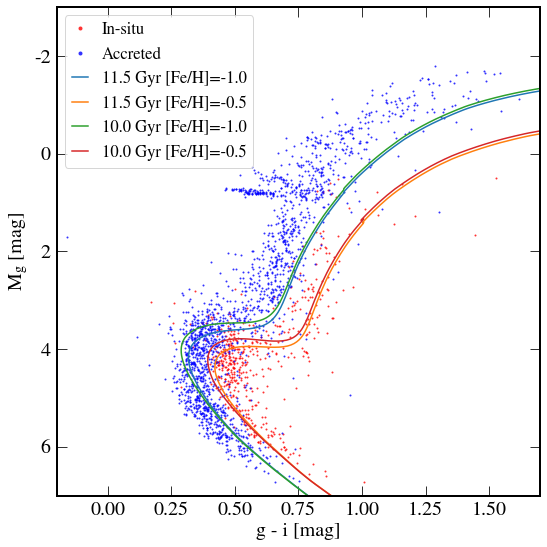

In [11]:
dm = 5*np.log10(t['dist_adpt']*1e3) - 5
N = min(np.sum(ind_splash), np.sum(ind_ge))
N = -1

plt.plot(t['PS_G'][ind_splash][:N] - t['PS_I'][ind_splash][:N], t['PS_G'][ind_splash][:N]-dm[ind_splash][:N],
         'ro', alpha=0.8, ms=2, mew=0, label='In-situ')
plt.plot(t['PS_G'][ind_ge][:N] - t['PS_I'][ind_ge][:N], t['PS_G'][ind_ge][:N]-dm[ind_ge][:N],
         'bo', alpha=0.8, ms=2, mew=0, label='Accreted')

label_age = [11.5, 11.5, 10, 10]
label_feh = [-1, -0.5, -1, -0.5]

for e, iso in enumerate(isochrones):
#     dm = 5 * np.log10(2800) - 5
    i_gi = iso['PS_g']-iso['PS_i'] + 0.05
    i_g = iso['PS_g'] #+dm
    plt.plot(i_gi, i_g, '-', label='{:.1f} Gyr [Fe/H]={:.1f}'.format(label_age[e], label_feh[e]))

plt.legend(markerscale=2, handlelength=1, fontsize='small')
plt.xlim(-0.2,1.7)
plt.ylim(7,-3)
plt.xlabel('g - i [mag]')
plt.ylabel('$M_g$ [mag]')

plt.tight_layout()
# plt.savefig('../plots/cmd.png')

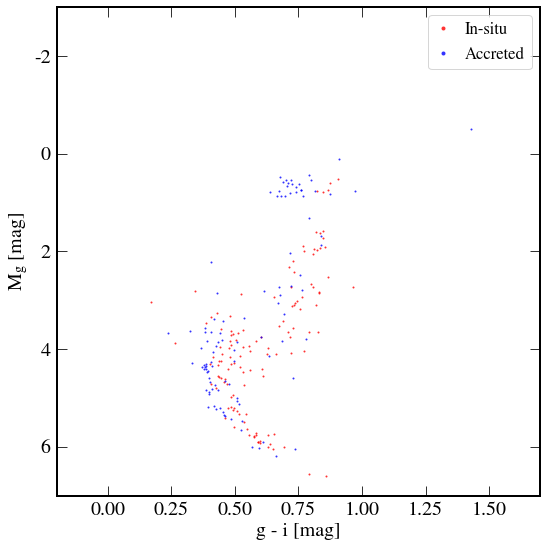

In [15]:
dm = 5*np.log10(t['dist_adpt']*1e3) - 5
# N = min(np.sum(ind_splash & ind_overlap), np.sum(ind_ge & ind_overlap))
N = -1

plt.plot(t['PS_G'][ind_splash & ind_overlap][:N] - t['PS_I'][ind_splash & ind_overlap][:N],
         t['PS_G'][ind_splash & ind_overlap & ind_overlap][:N]-dm[ind_splash & ind_overlap][:N],
         'ro', alpha=0.8, ms=2, mew=0, label='In-situ')
plt.plot(t['PS_G'][ind_ge & ind_overlap][:N] - t['PS_I'][ind_ge & ind_overlap][:N],
         t['PS_G'][ind_ge & ind_overlap][:N]-dm[ind_ge & ind_overlap][:N],
         'bo', alpha=0.8, ms=2, mew=0, label='Accreted')

label_age = [11.5, 11.5, 10, 10]
label_feh = [-1, -0.5, -1, -0.5]

# for e, iso in enumerate(isochrones):
# #     dm = 5 * np.log10(2800) - 5
#     i_gi = iso['PS_g']-iso['PS_i'] + 0.05
#     i_g = iso['PS_g'] #+dm
#     plt.plot(i_gi, i_g, '-', label='{:.1f} Gyr [Fe/H]={:.1f}'.format(label_age[e], label_feh[e]))

plt.legend(markerscale=2, handlelength=1, fontsize='small')
plt.xlim(-0.2,1.7)
plt.ylim(7,-3)
plt.xlabel('g - i [mag]')
plt.ylabel('$M_g$ [mag]')

plt.tight_layout()
# plt.savefig('../plots/cmd.png')

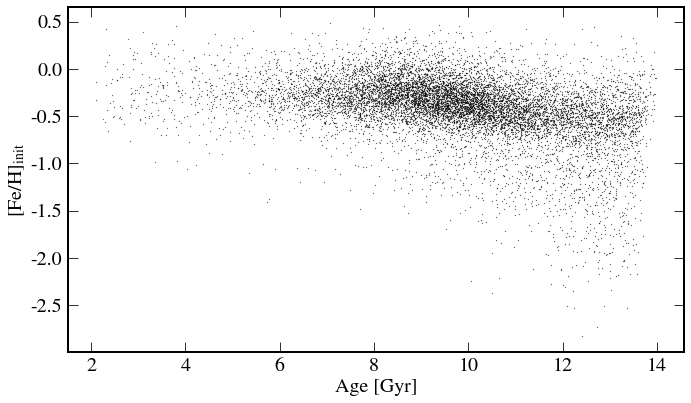

In [36]:
ind_mede = (t['eccen_pot1']>0.)

plt.figure(figsize=(10,6))

plt.plot(age[ind_mede & ind_safeage], t['init_FeH'][ind_mede & ind_safeage], 'k.', ms=0.5
        )
# plt.errorbar(age[ind_mede & ind_safeage], t['init_FeH'][ind_mede & ind_safeage],
#              xerr=(age_lerr[ind_mede & ind_safeage], age_uerr[ind_mede & ind_safeage]),
#              yerr=(t['init_FeH_lerr'][ind_mede & ind_safeage], t['init_FeH_uerr'][ind_mede & ind_safeage]),
#              fmt='none', color='k', alpha=0.1, lw=0.5)

plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]$_{init}$')
plt.tight_layout()